# VAR models: VAR, VARMA, VARMAX

### Notes

* The VAR model family comprises several varieties:
    * VAR: Vector Autoregressive
    * VARMA: Vector Autoregressive Moving Average
    * VARMAX: Vector Autoregressive Moving Average with Exogenous variables (=features)
* VAR models forecast a group of time series at once by adding autoregressive terms for all series to the regression equation of each series.
* VAR and VARMA are univariate models, whereas VARMAX is a multivariate model which requires forecasted features as inputs for forecasting.
* VAR models require stationary time series.
* Seasonality is usually handled outside of VAR models in a preceding step.

### References

* https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAX.html
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAXResults

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX

from lineartrend import LinearTrend
import tshelper as h

plt.style.use("seaborn-whitegrid")

## Load and prepare data

In [2]:
# Load data
df = pd.read_csv("data/catalog_seasfac.csv",
                 usecols=["date", "men", "women", "jewel", "mail", "page", "phone", "print", "service"],
                 index_col = "date")

# Convert index to PeriodIndex
df.index = pd.to_datetime(df.index).to_period("M")

In [3]:
# Define features and targets
targets = ["men", "women"]
features = ["mail", "page", "phone", "print", "service"]
Y = df[targets]
X = df[features]

# Show features and target
Y.join(X).head()

,men,women,mail,page,phone,print,service
date,,,,,,,
1989-01,11357.92,16578.93,7978,73,34,22294.48,20
1989-02,10605.95,18236.13,8290,88,29,27426.47,20
1989-03,16998.57,43393.55,8029,65,24,27978.66,26
1989-04,6563.75,30908.49,7752,85,20,28949.65,22
1989-05,6607.69,28701.58,8685,74,17,22642.27,21


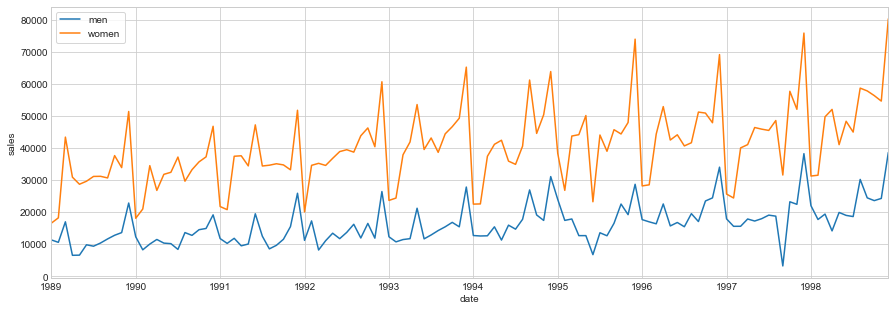

In [4]:
# Visualize targets
h.plot_series(*[Y[ta] for ta in targets], xlabel=df.index.name, ylabel="sales")

## Making time series stationary: De-trend targets

For the sake of simplicity, the linear trend models for making the time series stationary are fitted on the whole data set here, not just on the training data and then forecasted. In a real case, thee trends would have to be forecasted as well.

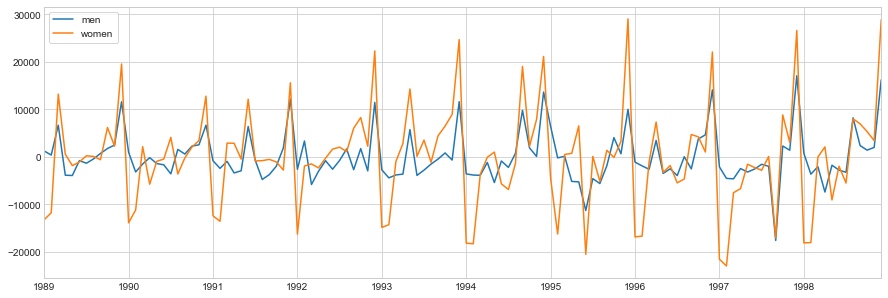

In [5]:
# De-trend targets with LinearTrend
Y_trend = pd.DataFrame(index=Y.index)
Y_dt = pd.DataFrame(index=Y.index)
for target in targets:
    model = LinearTrend(y=Y[target]).fit_ts()
    Y_trend[target] = model.predict_ts()
    Y_dt[target] = (Y[target] - Y_trend[target])
    
# Visualize de-trended features
h.plot_series(*[Y_dt[t] for t in targets])

## VAR model

In [6]:
# Train/test split
Y_train = Y_dt[:"1997"]
Y_test = Y_dt["1998"]

In [7]:
# Instantiate and train model with AR(2)
model = VARMAX(Y_train, exog=None, order=(2,0))
model = model.fit(maxiter=1000)
model.summary()

Dep. Variable:,"['men', 'women']",No. Observations:,108
Model:,VAR(2),Log Likelihood,-2160.693
,+ intercept,AIC,4347.386
Date:,"Sat, 16 Nov 2019",BIC,4382.254
Time:,16:26:36,HQIC,4361.524
Sample:,01-31-1989,,
,- 12-31-1997,,
Covariance Type:,opg,,
Ljung-Box (Q):,"90.20, 36.82",Jarque-Bera (JB):,"31.85, 1.27"
Prob(Q):,"0.00, 0.61",Prob(JB):,"0.00, 0.53"
Heteroskedasticity (H):,"2.12, 1.51",Skew:,"0.75, 0.07"



>> men
R-squared:               0.0344
Root mean squared error: 6134.2660
Mean absolute error:     4508.5750

>> women
R-squared:               0.0563
Root mean squared error: 10762.1282
Mean absolute error:     8049.5246


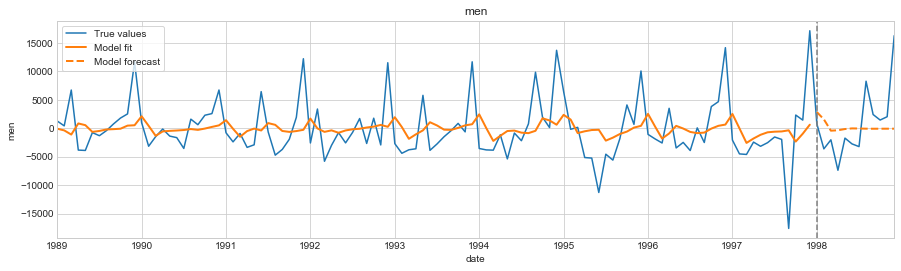

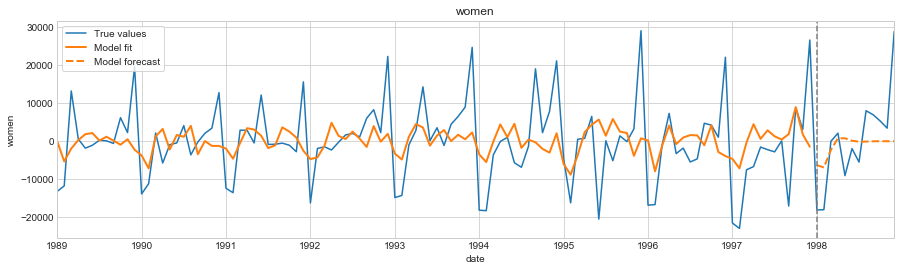

In [8]:
# Predict and forecast
Y_pred = model.predict()
Y_fcst = model.forecast(12)

# Evaluate model on test set 
for target in targets:
    print("\n>>", target)
    h.eval_model(Y_test[target], Y_fcst[target])
    
# Visualize fit and forecast
for target in targets:
    h.plot_model(Y_dt[target], Y_pred[target], Y_fcst[target], 
                 xlabel=Y.index.name, ylabel=target, title=target)

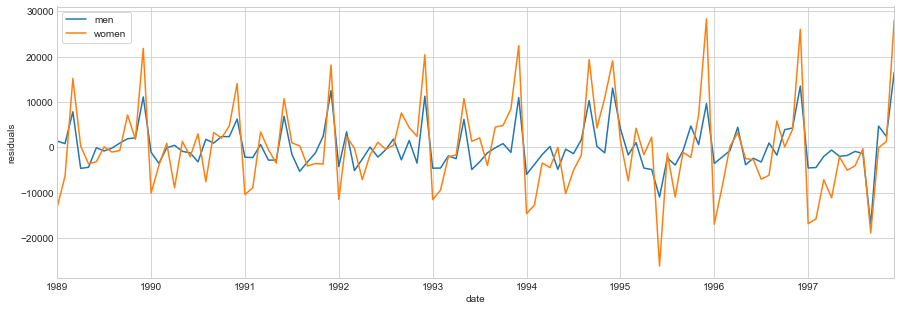

In [9]:
# Plot residuals
residuals = Y_train - Y_pred
h.plot_series(*[residuals[t] for t in targets], xlabel=residuals.index.name, ylabel="residuals")

## VARMA model

In [10]:
# Train/test split
Y_train = Y_dt[:"1997"]
Y_test = Y_dt["1998"]

In [11]:
# Instantiate and train model - AR(2) MA(2)
model = VARMAX(Y_train, exog=None, order=(2,2))
model = model.fit(maxiter=1000)
model.summary()

C:\Users\chris\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


Dep. Variable:,"['men', 'women']",No. Observations:,108
Model:,"VARMA(2,2)",Log Likelihood,-2147.313
,+ intercept,AIC,4336.627
Date:,"Sat, 16 Nov 2019",BIC,4392.952
Time:,16:26:52,HQIC,4359.464
Sample:,01-31-1989,,
,- 12-31-1997,,
Covariance Type:,opg,,
Ljung-Box (Q):,"62.82, 44.73",Jarque-Bera (JB):,"31.16, 1.46"
Prob(Q):,"0.01, 0.28",Prob(JB):,"0.00, 0.48"
Heteroskedasticity (H):,"1.76, 1.17",Skew:,"0.30, -0.06"


C:\Users\chris\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)



>> men
R-squared:               0.3027
Root mean squared error: 6412.1995
Mean absolute error:     4967.5217

>> women
R-squared:               0.0969
Root mean squared error: 11202.5173
Mean absolute error:     8384.0551


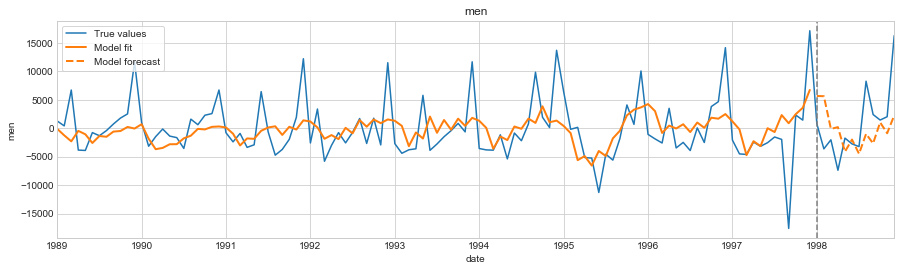

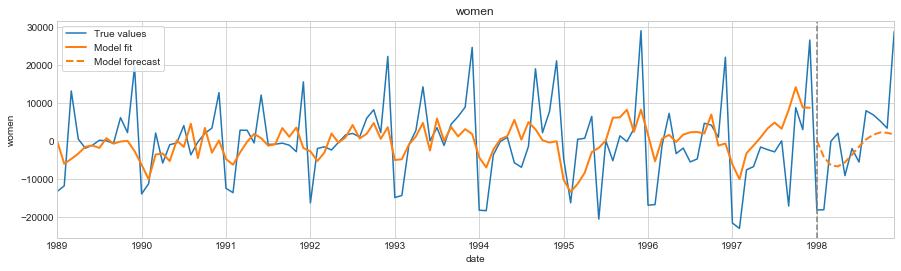

In [12]:
# Predict and forecast
Y_pred = model.predict()
Y_fcst = model.forecast(12)

# Evaluate model on test set 
for target in targets:
    print("\n>>", target)
    h.eval_model(Y_test[target], Y_fcst[target])
    
# Visualize fit and forecast
for target in targets:
    h.plot_model(Y_dt[target], Y_pred[target], Y_fcst[target], 
                 xlabel=Y.index.name, ylabel=target, title=target)

## VARMAX model


### De-trend features with LinearTrend

For the sake of simplicity, the linear trend models for making the time series stationary are again fitted on the whole data set here, not just on the training data. In a real case, linear trends would have to be forecasted as well.

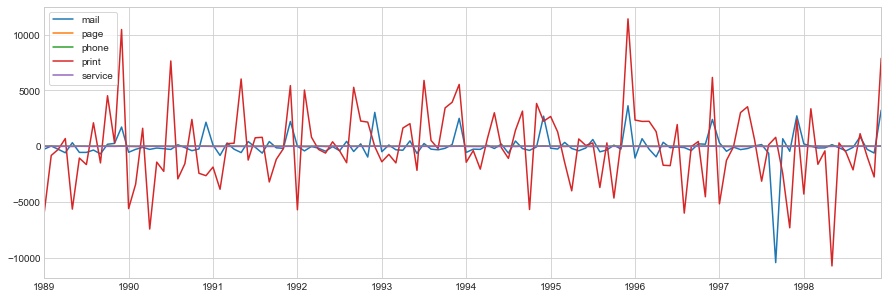

In [13]:
# De-trend features with LinearTrend
X_trend = pd.DataFrame(index=X.index)
X_dt = pd.DataFrame(index=X.index)
for feature in features:
    model = LinearTrend(y=X[feature]).fit_ts()
    X_trend[feature] = model.predict_ts()
    X_dt[feature] = X[feature] - X_trend[feature]
    
# Visualize de-trended features
h.plot_series(*[X_dt[f] for f in features])

In [14]:
# Train/test split
Y_train = Y_dt[:"1997"]
X_train = X_dt[:"1997"]
Y_test = Y_dt["1998"]
X_test = X_dt["1998"]

In [15]:
# Instantiate and train model - AR(2) MA(0)
model = VARMAX(Y_train, exog=X_train, order=(2,0))
model = model.fit(maxiter=1000)
model.summary()

Dep. Variable:,"['men', 'women']",No. Observations:,108
Model:,VARX(2),Log Likelihood,-2046.618
,+ intercept,AIC,4139.237
Date:,"Sat, 16 Nov 2019",BIC,4200.926
Time:,16:26:55,HQIC,4164.249
Sample:,01-31-1989,,
,- 12-31-1997,,
Covariance Type:,opg,,
Ljung-Box (Q):,"62.97, 55.70",Jarque-Bera (JB):,"31.93, 4.15"
Prob(Q):,"0.01, 0.05",Prob(JB):,"0.00, 0.13"
Heteroskedasticity (H):,"1.76, 1.36",Skew:,"0.85, -0.43"



>> men
R-squared:               0.5133
Root mean squared error: 3906.4124
Mean absolute error:     3264.2184

>> women
R-squared:               0.7798
Root mean squared error: 6861.0817
Mean absolute error:     4855.4193


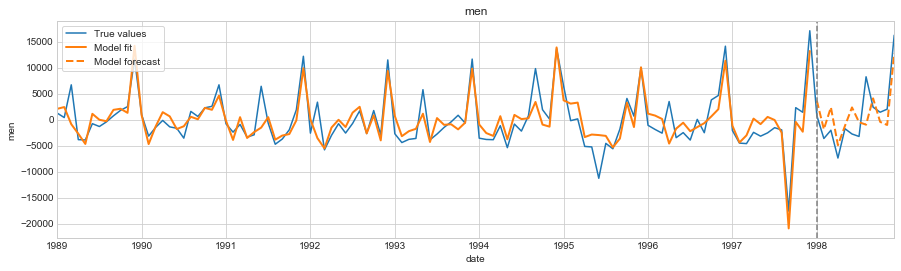

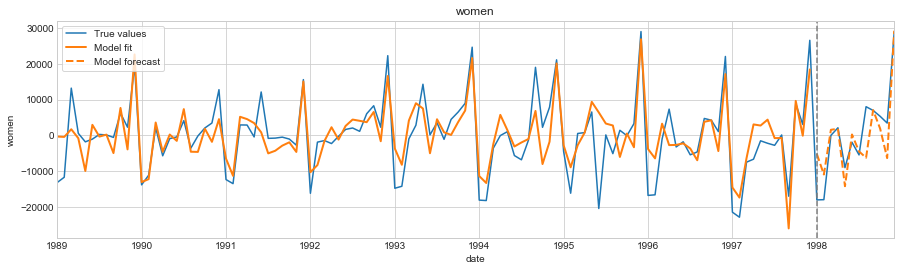

In [16]:
# Predict 
Y_pred = model.predict()

# "Forecast" features using test data
X_fcst = X_test

# Forecast targets
Y_fcst = model.forecast(steps=12, exog=X_fcst)

# Evaluate model on test set 
for target in targets:
    print("\n>>", target)
    h.eval_model(Y_test[target], Y_fcst[target])

# Visualize fit and forecast
for target in targets:
    h.plot_model(Y_dt[target], Y_pred[target], Y_fcst[target], 
                 xlabel=Y.index.name, ylabel=target, title=target)